# Black-Scholes Deep Learning
### Robbie Culkin and Sanjiv Das

In [1]:
%pylab inline
import pandas

Populating the interactive namespace from numpy and matplotlib


## The Closed-Form Black-Scholes (1973) Option Pricing Model

In [2]:
from scipy.stats import norm
def BSM(S,K,T,sig,rf,dv,cp):  #cp = {+1.0 (calls), -1.0 (puts)}
    d1 = (math.log(S/K)+(rf-dv+0.5*sig**2)*T)/(sig*math.sqrt(T))
    d2 = d1 - sig*math.sqrt(T)
    return cp*S*math.exp(-dv*T)*norm.cdf(d1*cp) - cp*K*math.exp(-rf*T)*norm.cdf(d2*cp)

## Read in data

In [3]:
df = pandas.read_csv('training.csv')

## Normalizing spot and call prices
$C$ is homogeneous degree one, so
$$ aC(S,K) = C(aS,aK) $$
This means we can normalize spot and call prices and remove  a variable by dividing by $K$.
$$ \frac{C(S,K)}{K} = C(S/K,1) $$

In [4]:
df['Stock Price'] = df['Stock Price']/df['Strike Price']
df['Call Price']  = df['Call Price'] /df['Strike Price']

## Partition data into training and testing sets

In [5]:
n = 300000
n_train =  (int)(0.8 * n)

In [6]:
train = df[0:n_train]
X_train = train[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_train = train['Call Price'].values

In [7]:
test = df[n_train+1:n]
X_test = test[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_test = test['Call Price'].values

## Import libraries

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

Using TensorFlow backend.


## Define custom activation function
The exponential is used because it returns positive-only values

In [9]:
def custom_activation(x):
    return backend.exp(x)

## Set up, compile and fit the model

In [10]:
nodes = 120
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation(custom_activation))
          
model.compile(loss='mse',optimizer='rmsprop')

In [11]:
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

Train on 216000 samples, validate on 24000 samples
Epoch 1/10
17s - loss: 0.0055 - val_loss: 0.0033
Epoch 2/10
13s - loss: 0.0014 - val_loss: 5.3688e-04
Epoch 3/10
13s - loss: 0.0010 - val_loss: 3.8997e-04
Epoch 4/10
16s - loss: 8.5241e-04 - val_loss: 9.3191e-04
Epoch 5/10
15s - loss: 7.4719e-04 - val_loss: 9.0098e-05
Epoch 6/10
13s - loss: 6.7518e-04 - val_loss: 2.7996e-04
Epoch 7/10
13s - loss: 6.2681e-04 - val_loss: 4.0878e-04
Epoch 8/10
13s - loss: 6.0006e-04 - val_loss: 2.3095e-04
Epoch 9/10
13s - loss: 5.7559e-04 - val_loss: 2.9597e-04
Epoch 10/10
13s - loss: 5.6009e-04 - val_loss: 6.0999e-04


In [12]:
#model.save("BSNN.h5")

In [13]:
# from keras.models import load_model
# model = load_model("BSNN.h5")

## Define method for checking and visualizing accuracy of predictions

In [14]:
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print "Mean Squared Error:      ", stats['mse']
    
    stats['rmse'] = sqrt(stats['mse'])
    print "Root Mean Squared Error: ", stats['rmse']
    
    stats['mae'] = mean(abs(stats['diff']))
    print "Mean Absolute Error:     ", stats['mae']
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print "Mean Percent Error:      ", stats['mpe']
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats

## Check accuracy of predictions (In-Sample)

In [15]:
y_train_hat = model.predict(X_train)

In [16]:
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = squeeze(y_train_hat)

Mean Squared Error:       0.000613722060277
Root Mean Squared Error:  0.0247734143847
Mean Absolute Error:      0.0216200344926
Mean Percent Error:       0.0926310698498


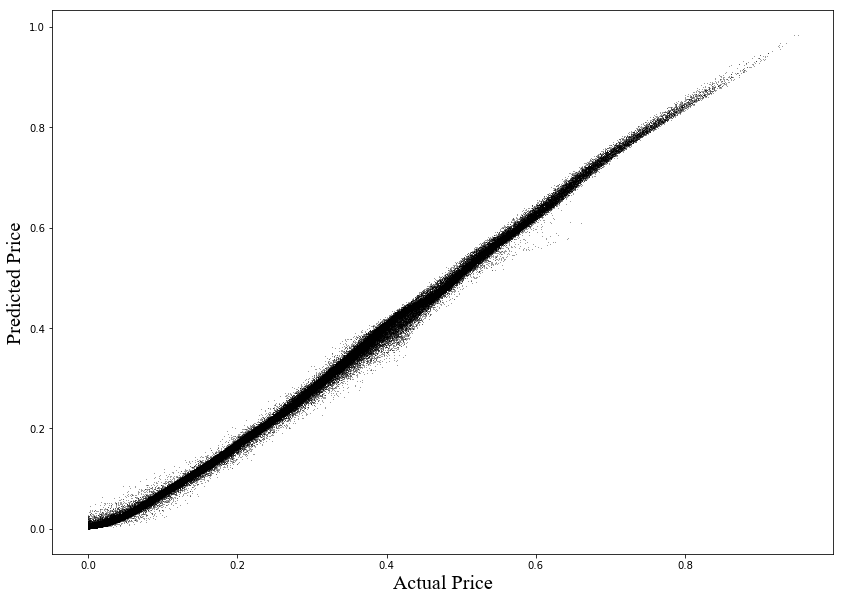

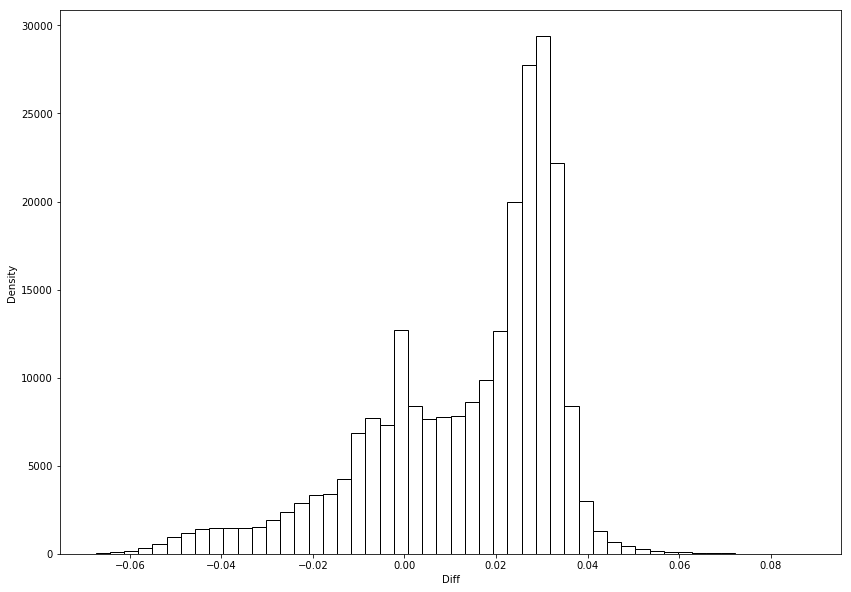

{'diff': array([ 0.03357341,  0.03262947,  0.0330477 , ...,  0.03088909,
         0.03261979,  0.02770595]),
 'mae': 0.021620034492598215,
 'mpe': 0.092631069849762174,
 'mse': 0.00061372206027671507,
 'rmse': 0.024773414384713203}

In [17]:
CheckAccuracy(y_train, y_train_hat)

## Check accuracy of predictions (Validation)

In [18]:
y_test_hat = model.predict(X_test)

In [19]:
#reduce dim (240000,1) -> (240000,) to match y_test's dim 
y_test_hat = squeeze(y_test_hat)

Mean Squared Error:       0.000612905692
Root Mean Squared Error:  0.0247569322009
Mean Absolute Error:      0.0216115563351
Mean Percent Error:       0.0926310538506


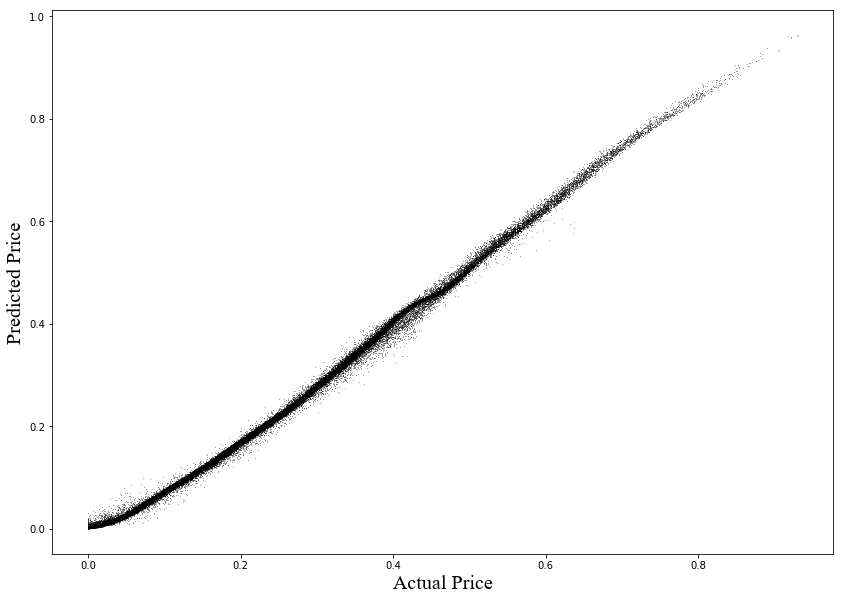

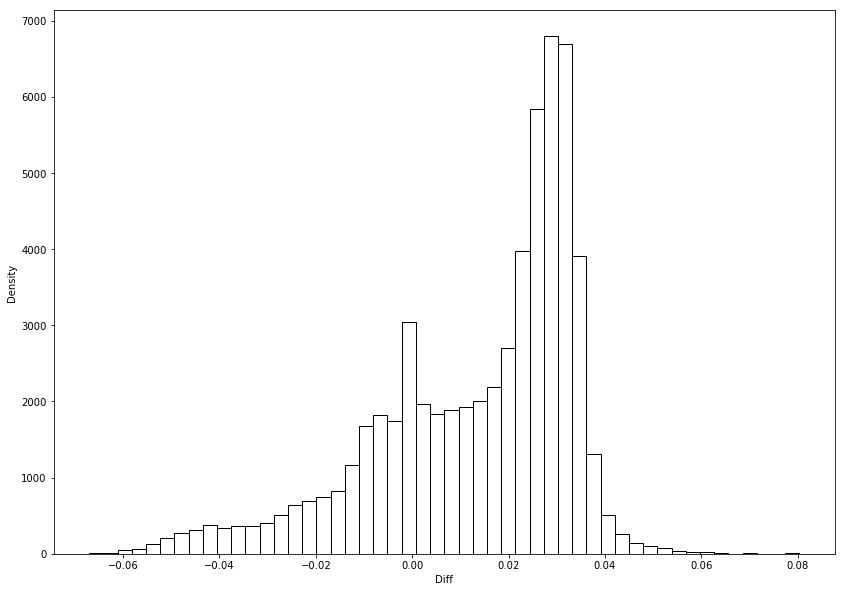

In [20]:
test_stats = CheckAccuracy(y_test, y_test_hat)

## Plot absolute error by option price size (moneyness)

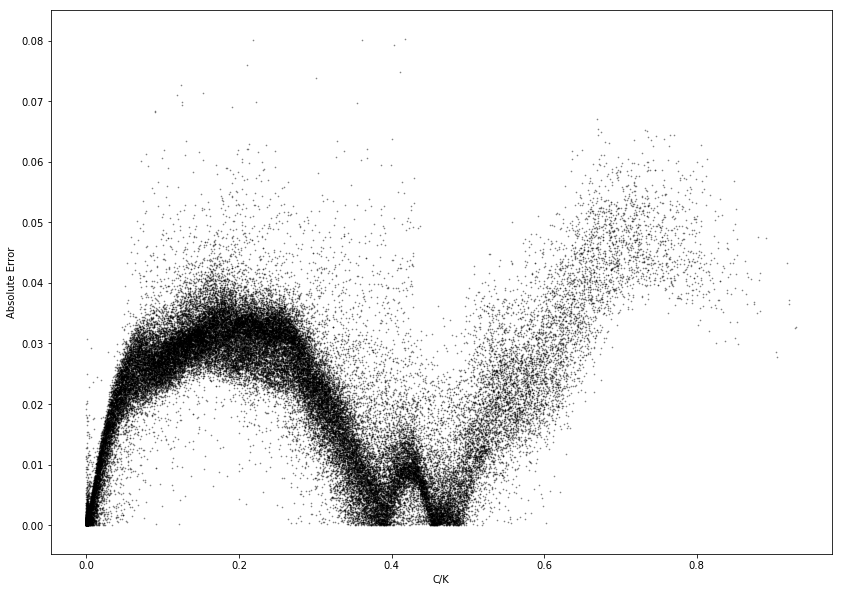

In [21]:
figure(figsize=(14,10))
plt.ylabel('Absolute Error')
plt.xlabel('C/K')
plt.scatter(y_test ,abs(test_stats['diff']), alpha=0.4, s=0.5,color='black');

## Plot percentage error by option price size (moneyness)

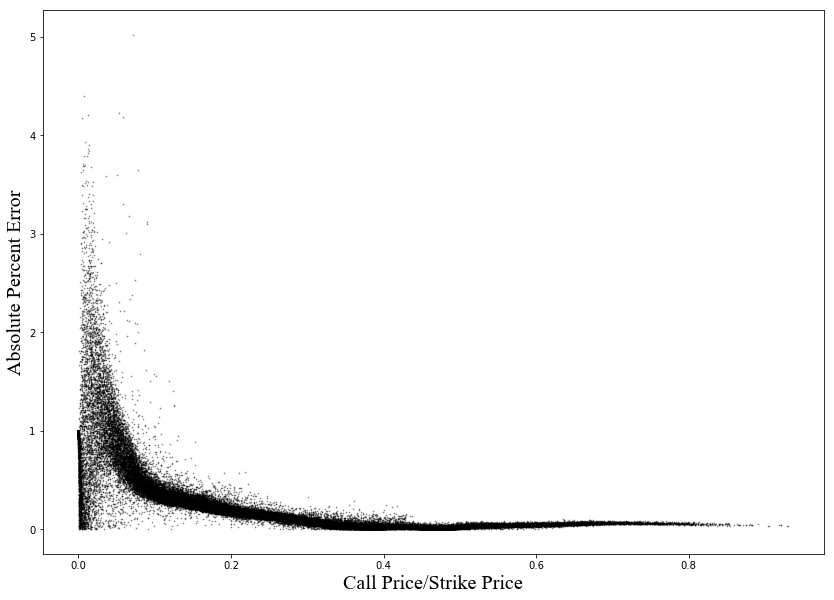

In [22]:
figure(figsize=(14,10))
plt.ylabel('Absolute Percent Error',fontsize=20,fontname='Times New Roman')
plt.xlabel('Call Price/Strike Price',fontsize=20,fontname='Times New Roman')
plt.scatter(y_test ,abs(test_stats['diff']/y_test_hat), alpha=0.4, s=0.5,color='black');

## Use the builtin Keras 'evaluate' function

In [23]:
model.evaluate(X_test, y_test, batch_size=32, verbose=2)

0.00061290569501207444

## Check against the closed BSM form

In [24]:
S=100.0
K=99.0
T=1.0 
dv=0.0
sig=0.2
rf=0.03

In [25]:
BSM(S,K,T,sig,rf,dv,1)

9.9276646169718177

In [26]:
X_check = np.array((S/K,T,dv,sig,rf))
X_check = X_check[None,:]

print K*model.predict(X_check)[0][0]

7.71153572202


## Compare to a Random Forest of decision trees

Mean Squared Error:       5.12432515065e-05
Root Mean Squared Error:  0.00715843918089
Mean Absolute Error:      0.00525566786559
Mean Percent Error:       0.0267841653348


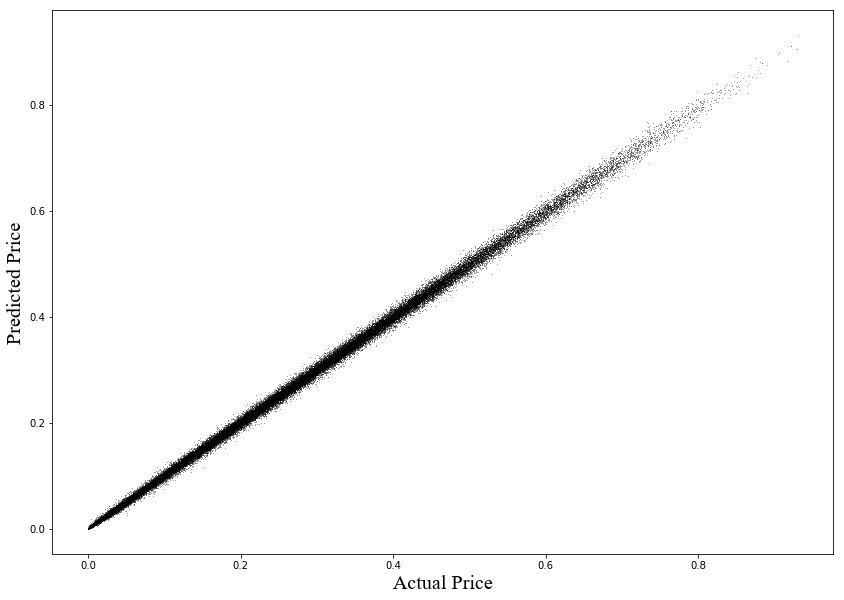

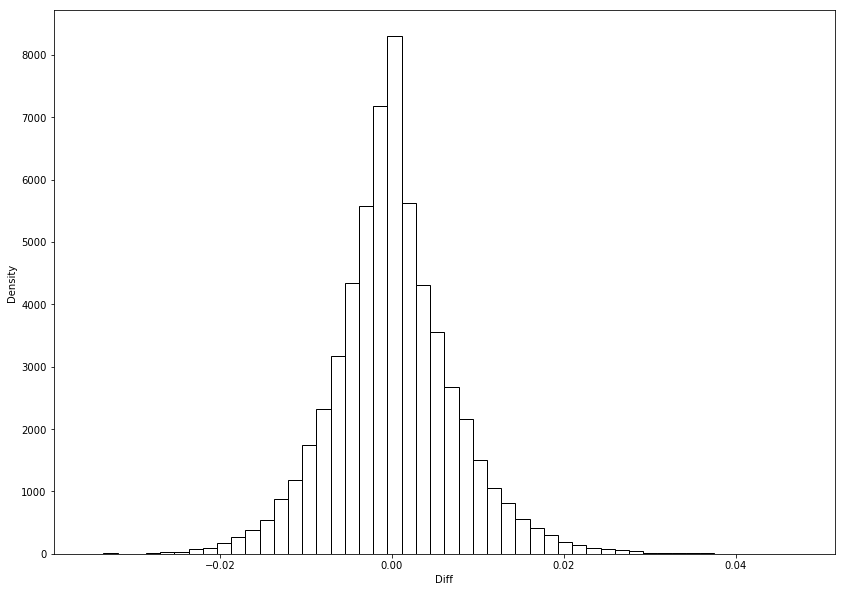

{'diff': array([-0.00532826,  0.00234648, -0.00022319, ...,  0.00046759,
        -0.00014556, -0.00149182]),
 'mae': 0.0052556678655947169,
 'mpe': 0.026784165334793029,
 'mse': 5.1243251506481288e-05,
 'rmse': 0.0071584391808886165}

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)
y_test_hat = forest.predict(X_test)

CheckAccuracy(y_test, y_test_hat)